In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cluster
import requests
from BinanceCollector import BinanceCollector
import warnings
import talib
warnings.filterwarnings("ignore")

In [52]:
collector = BinanceCollector("APEUSDT","2022-06-01","2022-12-19","15m")
collector.start_collect()
collector.df.columns = ["Open Time","Open","High","Low","Close","Volume","Close Time",
             "Quote asset volumne","Total Trades","Buyer Base Volume",
             "Taker buy quote asset volume","Ignore"]
df = collector.df

In [80]:
df = df[["Open","High","Low","Close","Volume","Total Trades","Buyer Base Volume","Taker buy quote asset volume"]]
df["Change"] = (df["Close"] - df["Open"])*100/df["Open"] 
df["Next Change"] = df["Change"].shift(-1) 
df["Buyer Volume Change"] = (df["Buyer Base Volume"] - df["Buyer Base Volume"].shift(1))*100 /df["Buyer Base Volume"].shift(1) 

<AxesSubplot:>

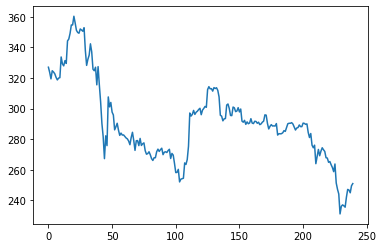

In [81]:
ema12 = df["Close"].ewm(span=12).mean()
ema26 = df["Close"].ewm(span=26).mean()
df["Close"].plot()

In [82]:
df["EMA 12"] = ema12
df["EMA 26"] = ema26
# df.loc[ (df["EMA 12"] > df["EMA 26"]) & (df["EMA 12"].shift(1) < df["EMA 26"].shift(1)) , "Buy"] = True
t = df["EMA 12"] > df["EMA 26"]
t2 = t.shift(1)
df["Crossover"] = np.where( t == t2, False, True )
df["Difference"] = df["EMA 12"] - df["EMA 26"]
df["Difference"] = df["Difference"] * 100 / df["Open"]

In [83]:
df.tail()

,Open,High,Low,Close,Volume,Total Trades,Buyer Base Volume,Taker buy quote asset volume,Change,Next Change,Buyer Volume Change,EMA 12,EMA 26,Crossover,Difference
235,246.5,254.6,245.1,247.2,168057.285,65338.0,88214.437,2.196029e+07,0.283976,-0.202184,91.921061,245.416914,255.092961,False,-3.925374
236,247.3,248.8,243.9,246.8,76626.422,39256.0,39314.640,9.694868e+06,-0.202184,-0.729335,-55.432873,245.629697,254.478668,False,-3.578233
237,246.8,247.9,244.8,245.0,38043.417,27637.0,19233.045,4.737927e+06,-0.729335,1.877551,-51.079178,245.532820,253.776544,False,-3.340245
238,245.0,251.5,244.6,249.6,91304.154,41486.0,49513.195,1.231298e+07,1.877551,0.560897,157.438149,246.158540,253.467171,False,-2.983115
239,249.6,253.9,248.1,251.0,71515.155,37379.0,37402.071,9.386333e+06,0.560897,NaN,-24.460397,246.903380,253.284417,False,-2.556505


In [ ]:
df.head()

In [70]:
# df[ df["Next Change"] > 0.5 ]
df.describe()

,Open,High,Low,Close,Volume,Total Trades,Buyer Base Volume,Taker buy quote asset volume,Change,Next Change,Buyer Volume Change,EMA 12,EMA 26,Difference
count,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,3.800000e+02,380.000000,379.000000,379.000000,380.000000,380.000000,380.000000
mean,249.113684,249.874737,248.325526,249.069737,6605.284061,3083.984211,3238.392932,7.910029e+05,-0.015849,-0.015497,35.998738,249.291038,249.595541,-0.128159
std,11.681531,11.420633,11.834285,11.646892,8573.625128,3796.541706,3979.558461,9.452215e+05,0.485851,0.486444,180.309824,11.626165,11.575001,0.603785
min,220.400000,223.100000,220.000000,220.400000,713.984000,655.000000,222.366000,5.815345e+04,-4.270315,-4.270315,-82.767404,228.288232,230.540113,-2.182300
25%,239.475000,240.700000,238.400000,239.450000,2452.347750,1550.250000,1228.605250,3.038831e+05,-0.198969,-0.199446,-38.649886,238.021234,238.355328,-0.368427
50%,247.850000,248.550000,247.000000,247.900000,3910.917000,2116.000000,1937.888000,4.782876e+05,0.000000,0.000000,0.330792,247.025280,246.676098,-0.018651
75%,261.400000,261.700000,260.900000,261.400000,7167.179000,3204.750000,3647.427500,8.777730e+05,0.189197,0.189359,60.260531,261.429681,261.290143,0.248304
max,268.000000,268.000000,267.000000,267.600000,93953.404000,54601.000000,37759.535000,8.850423e+06,2.606429,2.606429,2365.060509,267.600000,267.600000,1.118066


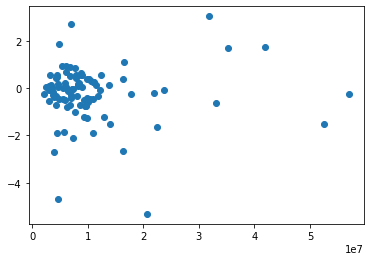

In [7]:
df.dropna(inplace=True)
plt.scatter( df["Taker buy quote asset volume"],df["Next Change"] )
# plt.plot(x,y)


In [95]:
df.dropna(inplace=True)
feature_matrix = df[ ["Volume","Total Trades","Change","Buyer Volume Change","Taker buy quote asset volume","Buyer Base Volume","Difference"] ]
# feature_matrix.dropna(inplace=True)
feature_matrix = np.array(feature_matrix)

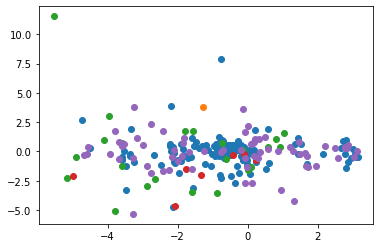

In [96]:
nc = 5
kmeans = cluster.KMeans(init="k-means++",n_init=nc,n_clusters=nc,random_state=0)
fig,ax = plt.subplots()
kmeans.fit(feature_matrix[:,:])
labels = kmeans.predict(feature_matrix[:,:])
for label in range(nc):
    ax.scatter(df["Difference"][labels == label],df["Next Change"][labels == label])

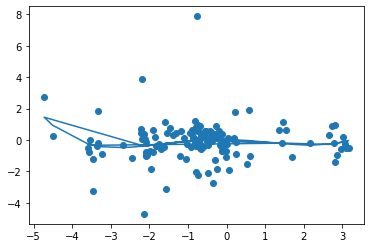

In [105]:
label = 0
x = feature_matrix[:,-1][labels == label]
y = df["Next Change"][labels == label]
tmp = np.polyfit(x,y,4)
fit = np.poly1d(tmp)
plt.scatter(x,y)
plt.plot(x,fit(x))

In [35]:
fit(feature_matrix[-1,-1])

-7292780.389474869

In [36]:
tmp = df[ df["Buyer Volume Change"] > 500 ]
len(tmp)

33

In [38]:
len(tmp[ tmp["Next Change"] > 0 ])

17

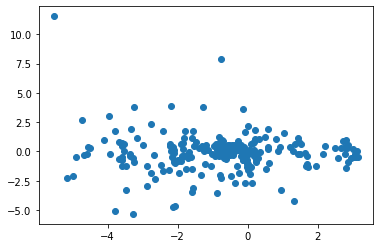

In [88]:
tmp = df[ abs(df["Difference"]) > 2 ]
tmp = df
plt.scatter( tmp["Difference"], tmp["Next Change"] )

<AxesSubplot:>

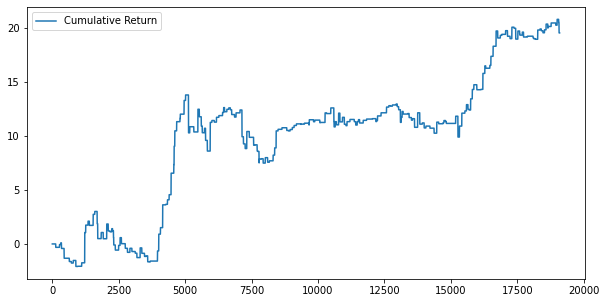

In [42]:
import pandas as pd
import numpy as np

# Load the data
# data = pd.read_csv("data.csv", parse_dates=True, index_col="Date")
data = df

# Compute the moving averages
data["SMA_50"] = data["Close"].rolling(window=20).mean()
data["SMA_200"] = data["Close"].rolling(window=50).mean()

# Initialize the signals
data["Signal"] = np.where((data["SMA_50"] > data["SMA_200"]) & (data["SMA_50"].shift(1) <= data["SMA_200"].shift(1)), 1, 0)

# Shift the signals one day forward
data["Signal"] = data["Signal"].shift(1)

# Calculate the returns
data["Return"] = (data["Close"] - data["Open"])*100/data["Open"]

# Calculate the strategy returns
data["Strategy Return"] = data["Signal"] * data["Return"]

# Calculate the cumulative returns
data["Cumulative Return"] = data["Strategy Return"].cumsum()

# Plot the returns
data[["Cumulative Return"]].plot(figsize=(10, 5))


In [27]:
data["Strategy Return"].describe()

count    19094.000000
mean         0.000009
std          0.000812
min         -0.035474
25%          0.000000
50%          0.000000
75%          0.000000
max          0.027642
Name: Strategy Return, dtype: float64

<AxesSubplot:>

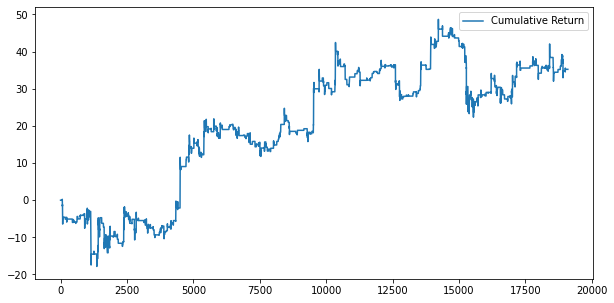

In [53]:
import pandas as pd
import numpy as np

# Load the data
# data = pd.read_csv("data.csv", parse_dates=True, index_col="Date")

# Calculate the RSI
data = df
data["RSI"] = talib.RSI(data["Close"], timeperiod=14)

# Initialize the signals
data["Signal"] = np.where((data["RSI"] > 70) | (data["RSI"] < 30), 1, 0)

# Shift the signals one day forward
data["Signal"] = data["Signal"].shift(1)

# Calculate the returns
data["Return"] = (data["Close"] - data["Open"])*100/data["Open"]

# Calculate the strategy returns
data["Strategy Return"] = data["Signal"] * data["Return"]

# Calculate the cumulative returns
data["Cumulative Return"] = data["Strategy Return"].cumsum()

# Plot the returns
data[["Cumulative Return"]].plot(figsize=(10, 5))
